## Gathering Data

In [1]:
import tweepy
import requests
import pandas as pd
import json
import math
import re
import time

In [2]:
# Import Twitter archive CSV file into DataFrame
arc_df = pd.read_csv('twitter_archive_enhanced.csv')

arc_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# My test when behind Proxy #1
print("Test #1")
requests.get("http://www.google.com")



Test #1


<Response [200]>

In [4]:
# Download tweet image predictions TSV using the Requests library and write to image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
# Import the tweet image predictions TSV file into DataFrame
img_df = pd.read_csv('image_predictions.tsv', sep='\t')

img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# Declare Twitter API keys and access tokens
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

In [6]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [7]:
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
# Using tweet IDs in the Twitter archive, query the Twitter API for each tweet's JSON
start = time.time() # start timer

with open('getstatus_error.txt', 'w') as errfile: 
    valid_ids = 0
    err_ids = 0
    tweet_ids = arc_df.tweet_id
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        for i, tweet_id in tweet_ids.iteritems():
            try:
                print("%s# %s" % (str(i+1), tweet_id))
                # Get tweet data using Twitter API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json_content = tweet._json
                
                # Write each tweet's JSON data to its own line in a file
                json.dump(json_content, outfile)
                outfile.write('\n')
                valid_ids += 1
            except tweepy.TweepError as e:
                err_ids += 1
                err_str = []
                err_str.append(str(tweet_id))
                err_str.append(': ')
                err_str.append(e.response.json()['errors'][0]['message'])
                err_str.append('\n')
                errfile.write(''.join(err_str))
                print(''.join(err_str))
            continue
        print("%s %s" % ('Valid tweets:', valid_ids))
        print("%s %s" % ('Error tweets:', err_ids))
        
end = time.time() # end timer
print((end - start)/(1000*60))

1# 892420643555336193
2# 892177421306343426
3# 891815181378084864
4# 891689557279858688
5# 891327558926688256


Rate limit reached. Sleeping for: 431


6# 891087950875897856
7# 890971913173991426
8# 890729181411237888
9# 890609185150312448
10# 890240255349198849
11# 890006608113172480
12# 889880896479866881
13# 889665388333682689
14# 889638837579907072
15# 889531135344209921
16# 889278841981685760
17# 888917238123831296
18# 888804989199671297
19# 888554962724278272
20# 888202515573088257
888202515573088257: No status found with that ID.

21# 888078434458587136
22# 887705289381826560
23# 887517139158093824
24# 887473957103951883
25# 887343217045368832
26# 887101392804085760
27# 886983233522544640
28# 886736880519319552
29# 886680336477933568
30# 886366144734445568
31# 886267009285017600
32# 886258384151887873
33# 886054160059072513
34# 885984800019947520
35# 885528943205470208
36# 885518971528720385
37# 885311592912609280
38# 885167619883638784
39# 884925521741709313
40# 884876753390489601
41# 884562892145688576
42# 884441805382717440
43# 884247878851493888
44# 884162670584377345
45# 883838122936631299
46# 883482846933004288
47# 883360

323# 834167344700198914
324# 834089966724603904
325# 834086379323871233
326# 833863086058651648
327# 833826103416520705
328# 833732339549220864
329# 833722901757046785
330# 833479644947025920
331# 833124694597443584
332# 832998151111966721
333# 832769181346996225
334# 832757312314028032
335# 832682457690300417
336# 832645525019123713
337# 832636094638288896
338# 832397543355072512
339# 832369877331693569
340# 832273440279240704
341# 832215909146226688
342# 832215726631055365
343# 832088576586297345
344# 832040443403784192
345# 832032802820481025
346# 831939777352105988
347# 831926988323639298
348# 831911600680497154
349# 831670449226514432
350# 831650051525054464
351# 831552930092285952
352# 831322785565769729
353# 831315979191906304
354# 831309418084069378
355# 831262627380748289
356# 830956169170665475
357# 830583320585068544
358# 830173239259324417
359# 830097400375152640
360# 829878982036299777
361# 829861396166877184
362# 829501995190984704
363# 829449946868879360
364# 82937434169

656# 791784077045166082
657# 791780927877898241
658# 791774931465953280
659# 791672322847637504
660# 791406955684368384
661# 791312159183634433
662# 791026214425268224
663# 790987426131050500
664# 790946055508652032
665# 790723298204217344
666# 790698755171364864
667# 790581949425475584
668# 790337589677002753
669# 790277117346975746
670# 790227638568808452
671# 789986466051088384
672# 789960241177853952
673# 789903600034189313
674# 789628658055020548
675# 789599242079838210
676# 789530877013393408
677# 789314372632018944
678# 789280767834746880
679# 789268448748703744
680# 789137962068021249
681# 788908386943430656
682# 788765914992902144
683# 788552643979468800
684# 788412144018661376
685# 788178268662984705
686# 788150585577050112
687# 788070120937619456
688# 788039637453406209
689# 787810552592695296
690# 787717603741622272
691# 787397959788929025
692# 787322443945877504
693# 787111942498508800
694# 786963064373534720
695# 786729988674449408
696# 786709082849828864
697# 78666495504

Rate limit reached. Sleeping for: 698


905# 758355060040593408
906# 758099635764359168
907# 758041019896193024
908# 757741869644341248
909# 757729163776290825
910# 757725642876129280
911# 757611664640446465
912# 757597904299253760
913# 757596066325864448
914# 757400162377592832
915# 757393109802180609
916# 757354760399941633
917# 756998049151549440
918# 756939218950160384
919# 756651752796094464
920# 756526248105566208
921# 756303284449767430
922# 756288534030475264
923# 756275833623502848
924# 755955933503782912
925# 755206590534418437
926# 755110668769038337
927# 754874841593970688
928# 754856583969079297
929# 754747087846248448
930# 754482103782404096
931# 754449512966619136
932# 754120377874386944
933# 754011816964026368
754011816964026368: No status found with that ID.

934# 753655901052166144
935# 753420520834629632
936# 753398408988139520
937# 753375668877008896
938# 753298634498793472
939# 753294487569522689
940# 753039830821511168
941# 753026973505581056
942# 752932432744185856
943# 752917284578922496
944# 75270194

1235# 712717840512598017
1236# 712668654853337088
1237# 712438159032893441
1238# 712309440758808576
1239# 712097430750289920
1240# 712092745624633345
1241# 712085617388212225
1242# 712065007010385924
1243# 711998809858043904
1244# 711968124745228288
1245# 711743778164514816
1246# 711732680602345472
1247# 711694788429553666
1248# 711652651650457602
1249# 711363825979756544
1250# 711306686208872448
1251# 711008018775851008
1252# 710997087345876993
1253# 710844581445812225
1254# 710833117892898816
1255# 710658690886586372
1256# 710609963652087808
1257# 710588934686908417
1258# 710296729921429505
1259# 710283270106132480
1260# 710272297844797440
1261# 710269109699739648
1262# 710153181850935296
1263# 710140971284037632
1264# 710117014656950272
1265# 709918798883774466
1266# 709901256215666688
1267# 709852847387627521
1268# 709566166965075968
1269# 709556954897764353
1270# 709519240576036864
1271# 709449600415961088
1272# 709409458133323776
1273# 709225125749587968
1274# 709207347839836162


1563# 688211956440801280
1564# 688179443353796608
1565# 688116655151435777
1566# 688064179421470721
1567# 687841446767013888
1568# 687826841265172480
1569# 687818504314159109
1570# 687807801670897665
1571# 687732144991551489
1572# 687704180304273409
1573# 687664829264453632
1574# 687494652870668288
1575# 687480748861947905
1576# 687476254459715584
1577# 687460506001633280
1578# 687399393394311168
1579# 687317306314240000
1580# 687312378585812992
1581# 687127927494963200
1582# 687124485711986689
1583# 687109925361856513
1584# 687102708889812993
1585# 687096057537363968
1586# 686947101016735744
1587# 686760001961103360
1588# 686749460672679938
1589# 686730991906516992
1590# 686683045143953408
1591# 686618349602762752
1592# 686606069955735556
1593# 686394059078897668
1594# 686386521809772549
1595# 686377065986265092
1596# 686358356425093120
1597# 686286779679375361
1598# 686050296934563840
1599# 686035780142297088
1600# 686034024800862208
1601# 686007916130873345
1602# 686003207160610816


Rate limit reached. Sleeping for: 692



1806# 676942428000112642
1807# 676936541936185344
1808# 676916996760600576
1809# 676897532954456065
1810# 676864501615042560
1811# 676821958043033607
1812# 676819651066732545
1813# 676811746707918848
1814# 676776431406465024
1815# 676617503762681856
1816# 676613908052996102
1817# 676606785097199616
1818# 676603393314578432
1819# 676593408224403456
1820# 676590572941893632
1821# 676588346097852417
1822# 676582956622721024
1823# 676575501977128964
1824# 676533798876651520
1825# 676496375194980353
1826# 676470639084101634
1827# 676440007570247681
1828# 676430933382295552
1829# 676263575653122048
1830# 676237365392908289
1831# 676219687039057920
1832# 676215927814406144
1833# 676191832485810177
1834# 676146341966438401
1835# 676121918416756736
1836# 676101918813499392
1837# 676098748976615425
1838# 676089483918516224
1839# 675898130735476737
1840# 675891555769696257
1841# 675888385639251968
1842# 675878199931371520
1843# 675870721063669760
1844# 675853064436391936
1845# 675849018447167488

2135# 670069087419133954
2136# 670061506722140161
2137# 670055038660800512
2138# 670046952931721218
2139# 670040295598354432
2140# 670037189829525505
2141# 670003130994700288
2142# 669993076832759809
2143# 669972011175813120
2144# 669970042633789440
2145# 669942763794931712
2146# 669926384437997569
2147# 669923323644657664
2148# 669753178989142016
2149# 669749430875258880
2150# 669684865554620416
2151# 669683899023405056
2152# 669682095984410625
2153# 669680153564442624
2154# 669661792646373376
2155# 669625907762618368
2156# 669603084620980224
2157# 669597912108789760
2158# 669583744538451968
2159# 669573570759163904
2160# 669571471778410496
2161# 669567591774625800
2162# 669564461267722241
2163# 669393256313184256
2164# 669375718304980992
2165# 669371483794317312
2166# 669367896104181761
2167# 669363888236994561
2168# 669359674819481600
2169# 669354382627049472
2170# 669353438988365824
2171# 669351434509529089
2172# 669328503091937280
2173# 669327207240699904
2174# 669324657376567296


In [9]:
# List of dictionaries to read tweet's JSON data line by line and later convert to DataFrame

df_list = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
# Append to list of dictionaries
        df_list.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count'],
                        'display_text_range': status['display_text_range']
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
status_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

## Assessing Data

In [10]:
arc_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2321,666435652385423360,NaN,NaN,2015-11-17 02:00:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Can you behave? You're ruining my wedding day...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/666435652...,10,10,None,None,None,None,None
247,845459076796616705,NaN,NaN,2017-03-25 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a heartwarming scene of ...,7.562885e+17,4.196984e+09,2016-07-22 00:43:32 +0000,https://twitter.com/dog_rates/status/756288534...,12,10,None,None,None,None,None
1477,693622659251335168,NaN,NaN,2016-01-31 02:31:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you keepin the popcorn bucket in your lap...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693622659...,10,10,None,None,None,None,None
151,862831371563274240,NaN,NaN,2017-05-12 00:46:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zooey. She's the world's biggest fan o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/862831371...,13,10,Zooey,None,None,None,None
1095,736392552031657984,NaN,NaN,2016-05-28 03:04:00 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Say hello to mad pupper. You know what you did...,NaN,NaN,NaN,https://vine.co/v/iEggaEOiLO3,13,10,mad,None,None,pupper,None


`arc_df` (Twitter archive) columns:
- **tweet_id**: the unique identifier for each tweet
- **in_reply_to_status_id**: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
- **in_reply_to_user_id**: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID
- **timestamp**: time when this Tweet was created
- **source**: utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
- **text**: actual UTF-8 text of the status update
- **retweeted_status_id**: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID
- **retweeted_status_user_id**: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID
- **retweeted_status_timestamp**: time of retweet
- **expanded_urls**: tweet URL
- **rating_numerator**: numerator of the rating of a dog. Note: ratings almost always greater than 10
- **rating_denominator**: denominator of the rating of a dog. Note: ratings almost always have a denominator of 10
- **name**: name of the dog
- **doggo**: one of the 4 dog "stage"
- **floofer**: one of the 4 dog "stage"
- **pupper**: one of the 4 dog "stage"
- **puppo**: one of the 4 dog "stage"

In [11]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
# Check if there are any records in arc_df which are retweets
len(arc_df[arc_df.retweeted_status_id.isnull() == False])

181

In [13]:
# Check if there are any records in arc_df whose corresponding record with same tweet_id is missing in img_df table
len(arc_df[~arc_df.tweet_id.isin(img_df.tweet_id)])

281

In [14]:
# Sort by rating_denominator values
arc_df.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [15]:
# Sort by rating_numerator values
arc_df.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [16]:
arc_df.name.value_counts().sort_index(ascending=False)

very             5
unacceptable     1
this             1
the              8
such             1
space            1
quite            4
one              4
old              1
officially       1
not              2
my               1
mad              2
light            1
life             1
just             4
infuriating      1
incredibly       1
his              1
getting          2
by               1
an               7
all              1
actually         2
a               55
Zuzu             1
Zooey            1
Zoey             3
Zoe              1
Ziva             1
                ..
Apollo           1
Antony           1
Anthony          1
Anna             1
Angel            1
Andy             1
Andru            1
Anakin           2
Amélie           1
Amy              1
Ambrose          1
Amber            1
Alice            2
Alfy             1
Alfie            5
Alf              1
Alexanderson     1
Alexander        1
Alejandro        1
Aldrick          1
Albus            2
Albert      

In [17]:
# Number of records whose both doggo and floofer columns are not None
len(arc_df[(arc_df.doggo != 'None') & (arc_df.floofer != 'None')])

1

In [18]:
# Number of records whose both doggo and pupper columns are not None
len(arc_df[(arc_df.doggo != 'None') & (arc_df.pupper != 'None')])

12

In [19]:
# Number of records whose both doggo and pupper columns are not None
len(arc_df[(arc_df.doggo != 'None') & (arc_df.puppo != 'None')])

1

In [20]:
# Number of records whose both floofer and pupper columns are not None
len(arc_df[(arc_df.floofer != 'None') & (arc_df.pupper != 'None')])

0

In [21]:
# Number of records whose both floofer and puppo columns are not None
len(arc_df[(arc_df.floofer != 'None') & (arc_df.puppo != 'None')])

0

In [22]:
# Number of records whose both pupper and puppo columns are not None
len(arc_df[(arc_df.pupper != 'None') & (arc_df.puppo != 'None')])

0

In [23]:
img_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1615,802247111496568832,https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg,1,Chihuahua,0.721188,True,toy_terrier,0.112943,True,kelpie,0.053365,True
1045,712809025985978368,https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg,1,Labrador_retriever,0.868671,True,carton,0.095095,False,pug,0.007651,True
1714,818627210458333184,https://pbs.twimg.com/media/C1xZGkzWIAA8vh4.jpg,1,Labrador_retriever,0.384188,True,beagle,0.255917,True,grocery_store,0.079799,False
1366,761672994376806400,https://pbs.twimg.com/ext_tw_video_thumb/76167...,1,gondola,0.318851,False,sea_lion,0.306525,False,pool_table,0.111565,False
811,692417313023332352,https://pbs.twimg.com/media/CZv13u5WYAA6wQe.jpg,1,bison,0.208922,False,mink,0.169945,False,polecat,0.144494,False


`img_df` (tweet image predictions) columns:
- **tweet_id**: the unique identifier for each tweet
- **jpg_url**: dog's image URL
- **img_num**: the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
- **p1**: algorithm's #1 prediction for the image in the tweet
- **p1_conf**: how confident the algorithm is in its #1 prediction
- **p1_dog**: whether or not the #1 prediction is a breed of dog
- **p2**: algorithm's #2 prediction for the image in the tweet
- **p2_conf**: how confident the algorithm is in its #2 prediction
- **p2_dog**: whether or not the #2 prediction is a breed of dog
- **p3**: algorithm's #3 prediction for the image in the tweet
- **p3_conf**: how confident the algorithm is in its #3 prediction
- **p3_dog**: whether or not the #3 prediction is a breed of dog

In [24]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
status_df.sample(5)

,tweet_id,retweet_count,favorite_count,display_text_range
753,776477788987613185,2899,9199,"[0, 103]"
1931,673656262056419329,238,714,"[0, 140]"
228,847157206088847362,5952,20191,"[0, 139]"
1498,690728923253055490,528,2227,"[0, 108]"
2070,670780561024270336,287,781,"[0, 136]"


`status_df` (tweet status) columns:
- **id**: the unique identifier for each tweet
- **retweet_count**: number of times this Tweet has been retweeted
- **favorite_count**: indicates approximately how many times this Tweet has been liked by Twitter users
- **display_text_range**: an array of two unicode code point indices, identifying the inclusive start and exclusive end of the displayable content of the Tweet

In [26]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 4 columns):
tweet_id              2333 non-null int64
retweet_count         2333 non-null int64
favorite_count        2333 non-null int64
display_text_range    2333 non-null object
dtypes: int64(3), object(1)
memory usage: 73.0+ KB


### Quality
##### `arc_df` (Twitter archive) table
- contains retweets and therefore, duplicates
- many *tweet_id*(s) of `arc_df` table are missing in `img_df` (image predictions) table
- erroneous datatypes (*in_reply_to_status_id, in_reply_to_user_id and timestamp* columns)
- unnecessary html tags in *source* column in place of utility name e.g. `<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>`
- *text* column contains untruncated text instead of displayable text
- *rating_numerator* column has values less than 10 as well as some very large numbers (e.g. 1176)
- *rating_denominator* column has values other than 10
- erroneous dog names starting with lowercase characters (e.g. a, an, actually, by)
- some records have more than one dog stage

### Tidiness
- *doggo, floofer, pupper* and *puppo* columns in `arc_df` table should be merged into one column named *"stage"*
- *"breed"* column should be added in `arc_df` table; its values based on *p1_conf* and *p1_dog* columns of `img_df` (image predictions) table
- *retweet_count* and *favorite_count* columns from `status_df` (tweet status) table should be joined with `arc_df` table

---

## Cleaning Data

In [27]:
# Take a copy of arc_df on which the cleaning tasks will be performed
archive_clean = arc_df.copy()

### Quality

#### `arc_df`: contains retweets and therefore, duplicates

##### Define
Keep only those rows in `arc_df` table that are original tweets and NOT retweets (i.e. *retweeted_status_id* column is null). Delete the rest.

##### Code

In [28]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

##### Test

In [29]:
len(archive_clean[archive_clean.retweeted_status_id.isnull() == False])

0

#### `arc_df`: many *tweet_id*(s) of `arc_df` table are missing in `img_df` (image predictions) table

##### Define
Keep only those records in `arc_df` table whose *tweet_id* exists in `img_df` table

##### Code

In [30]:
archive_clean = archive_clean[archive_clean.tweet_id.isin(img_df.tweet_id)]

##### Test

In [31]:
len(archive_clean[~archive_clean.tweet_id.isin(img_df.tweet_id)])

0

### Quality

#### `arc_df` table without any duplicates (i.e. retweets) have empty *retweeted_status_id, retweeted_status_user_id* and *retweeted_status_timestamp* columns, which can be dropped

In [32]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: float64(4), int64(3), object(1

##### Define
Drop *retweeted_status_id, retweeted_status_user_id* and *retweeted_status_timestamp* columns from `arc_df` table

#### Code

In [33]:
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [34]:
archive_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 233.7+ KB


### Quality

#### `arc_df`: erroneous datatypes (*in_reply_to_status_id, in_reply_to_user_id* and *timestamp* columns)

##### Define
Convert *in_reply_to_status_id* and *in_reply_to_user_id* to data type integer. Convert *timestamp* to datetime data type

##### Code

In [35]:
import numpy as np

archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.fillna(0)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.fillna(0)

archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(np.int64)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(np.int64)

# Convert ID's to strings
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(np.str)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(np.str)
archive_clean.tweet_id = archive_clean.tweet_id.astype(np.str)
status_df.tweet_id = status_df.tweet_id.astype(np.str)
img_df.tweet_id = img_df.tweet_id.astype(np.str) 

archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

##### Test

In [36]:
img_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### `arc_df`: unnecessary html tags in *source* column in place of utility name e.g. `<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>`

##### Define
Strip all html anchor tags (i.e. `<a..></a>`) in *source* column and retain just the text in between the tags. Convert the datatype from string to categorical.

#### Code

In [37]:
archive_clean.source = archive_clean.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')

In [38]:
archive_clean.source = archive_clean.source.astype('category')

#### Test

In [39]:
archive_clean.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

#### `arc_df`: *text* column contains untruncated text instead of displayable text

##### Define
Using the *display_text_range* of `status_df` table, extract displayable text from text column

##### Code

In [40]:
# Before extraction: untruncated text of first 3 records
print(archive_clean.iloc[0].text)
print(archive_clean.iloc[1].text)
print(archive_clean.iloc[2].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB


In [41]:
# merge status_df's display_text_range column to archive_clean to extract text using range values
archive_clean = pd.merge(archive_clean, status_df[['tweet_id', 'display_text_range']], on='tweet_id')

In [42]:
status_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 4 columns):
tweet_id              2333 non-null object
retweet_count         2333 non-null int64
favorite_count        2333 non-null int64
display_text_range    2333 non-null object
dtypes: int64(2), object(2)
memory usage: 73.0+ KB


In [43]:
# using display_text_range of archive_clean, extract displayable text
for i, row in archive_clean.iterrows():
    text_range = row.display_text_range
    display_text = row.text[text_range[0]:text_range[1]]
    archive_clean.set_value(i, 'text', display_text)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


In [44]:
# drop display_text_range column
archive_clean.drop('display_text_range', axis=1, inplace=True)

##### Test

In [45]:
# After extraction: first 3 records now show displayable text
print(archive_clean.iloc[0].text)
print(archive_clean.iloc[1].text)
print(archive_clean.iloc[2].text)  

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10


#### `arc_df`: *rating_denominator* column has values other than 10

##### Define
For records whose *rating_denominator* is greater than 10 and divisible by 10, use the quotient as the divisor to divide the *rating_numerator*. If the numerator turns out to be divisible (i.e. remainder=0), assign this quotient as the *rating_numerator*.

For the remaining records, check if the *text* column contains any fraction whose denominator is 10. If it does, update the *rating_denominator* to 10. Additionally, update the *rating_numerator* with the numerator value of this fraction.

##### Code

In [46]:
# regex to match fractions
pattern = "\s*(\d+([.]\d+)?([/]\d+))"

# function which will match the above pattern and return an array of fractions, if any
def tokens(x):
  return [m.group(1) for m in re.finditer(pattern, x)]

In [47]:
# iterate through all those records whose rating_denominator is not 10
for i, row in archive_clean[archive_clean.rating_denominator != 10].iterrows():
    d = row.rating_denominator
    
    # if rating_denominator is greater than 10 and divisible by 10
    if d > 10 and d%10 == 0:
        # assign divisor as the quotient
        divisor = d/10
        n = row.rating_numerator
        
        # if rating_numerator is greater than 10 and divisible by the divisor
        if n%divisor == 0:
            # reassign rating_denominator as 10
            archive_clean.set_value(i, 'rating_denominator', 10)
            # reassign rating_numerator as the quotient of rating_numerator by divisor
            archive_clean.set_value(i, 'rating_numerator', int(n/divisor))
    
    # for all those records whose rating_denominator is either less than 10 or not divisible by 10
    else:
        # extract all fractions(ratings) from text using tokens function
        ratings = tokens(row.text)
        # iterate through all the fractions
        for rating in ratings:
            # if denominator of any such fraction is equal to 10
            if rating.split('/')[1] == '10':
                # reassign rating_denominator as 10
                archive_clean.set_value(i, 'rating_denominator', 10)
                # reassign rating_numerator as the numerator value of this fraction
                archive_clean.set_value(i, 'rating_numerator', int(round(float(rating.split('/')[0]))))
                break

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


##### Test

In [48]:
archive_clean.rating_denominator.value_counts()

10    1986
7        1
Name: rating_denominator, dtype: int64

#### `arc_df`: *rating_numerator* column has values less than or equal to 10 as well as some very large numbers (e.g. 1176)

##### Define
For all those records whose *rating numerator* is either less than or equal to 10 or greater than 10 but has a very high value, check if the text contains any fraction whose denominator is 10. If it does, update the *rating_numerator* with the numerator value of this fraction.

In [49]:
archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].rating_numerator.value_counts().sort_index()

0         2
1         4
2        10
3        19
4        15
5        33
6        32
7        51
8        95
9       152
10      421
24        1
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

##### Code

In [50]:
# for rows whose rating numerator is either less than or equal to 10 OR
# greater than 10 but has a very high value (consider greater than 14)
for i, row in archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].iterrows():
    ratings = tokens(row.text)
    for rating in ratings:        
        if rating.split('/')[1] == '10':
            n = int(round(float(rating.split('/')[0])))
            if (row.rating_numerator == 10 and n > 10) or (row.rating_numerator != 10 and n >= 10):
                archive_clean.set_value(i, 'rating_numerator', n)
                break

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


##### Test

In [51]:
archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].rating_numerator.value_counts().sort_index()

0         2
1         4
2         9
3        19
4        14
5        31
6        32
7        51
8        94
9       152
10      420
24        1
420       1
1776      1
Name: rating_numerator, dtype: int64

#### `arc_df`: erroneous dog names starting with lowercase characters (e.g. a, an, actually, by)

##### Define
Replace all lowercase values of *name* column with None

##### Code

In [52]:
archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


##### Test

In [53]:
archive_clean.name[archive_clean.name == 'None'].value_counts()

None    644
Name: name, dtype: int64

In [54]:
# Sort ascending by name to check if there are more names starting with a lowercase alphabet
archive_clean.name.value_counts().sort_index(ascending=False)

Zuzu            1
Zooey           1
Zoey            3
Zoe             1
Ziva            1
Zeus            1
Zeke            3
Zeek            1
Zara            1
Yogi            2
Yoda            1
Wyatt           3
Wishes          1
Winston         8
Winnie          4
Winifred        1
Wilson          3
Willy           1
Willow          1
Willie          1
William         1
Willem          1
Wiggles         1
Wesley          1
Watson          2
Walter          3
Wally           2
Wallace         3
Walker          1
Waffles         3
               ..
Apollo          1
Antony          1
Anthony         1
Anna            1
Angel           1
Andy            1
Andru           1
Anakin          1
Amélie          1
Amy             1
Ambrose         1
Amber           1
Alice           2
Alfy            1
Alfie           4
Alf             1
Alexanderson    1
Alexander       1
Alejandro       1
Aldrick         1
Albus           2
Albert          2
Al              1
Akumi           1
Aja       

#### `arc_df`: some records have more than one dog stage

In [56]:
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')]))
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.puppo != 'None')]))
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')]))

1
1
9


##### Define
There is one record that has both *doggo* and *floofer* and another record that has both *doggo* and *puppo*. For these 2 records, take a look at the text manually to decide one dog stage for each of them. For ambiguous texts, set both the column values as None.

There are 9 records which have both *doggo* and *pupper*. As per the dogtionary, *doggo* and *pupper* are sometimes used interchangeably. Therefore, set *pupper* column as None for these 9 records.

##### Code

In [57]:
for i, row in archive_clean[((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None'))
                   | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))].iterrows():
    print('%s %s\n'%(row.tweet_id, row.text))

855851453814013952 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for

854010172552949760 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs



In [58]:
# based on the above texts, doggo should be set as None for both the records
archive_clean['doggo'][archive_clean.tweet_id.isin([855851453814013952, 854010172552949760])] = 'None'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [59]:
# set pupper column as None for records which have both doggo and pupper
archive_clean['pupper'][(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')] = 'None'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Test

In [60]:
len(archive_clean[((archive_clean.doggo != 'None') & (archive_clean.pupper != 'None'))
                  | ((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')) 
                  | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))])

2

### Tidiness

#### doggo, floofer, pupper and puppo columns in `arc_df` table should be merged into one column named "stage"

In [61]:
archive_clean.doggo.value_counts()

None     1914
doggo      73
Name: doggo, dtype: int64

In [62]:
archive_clean.floofer.value_counts()

None       1979
floofer       8
Name: floofer, dtype: int64

In [63]:
archive_clean.pupper.value_counts()

None      1784
pupper     203
Name: pupper, dtype: int64

In [64]:
archive_clean.puppo.value_counts()

None     1964
puppo      23
Name: puppo, dtype: int64

##### Define
Merge the *doggo*, *floofer*, *pupper* and *puppo* columns to a *stage* column. Convert the datatype from string to categorical as it helps with analysis and visualization and saves memory on disk.

Drop the *doggo*, *floofer*, *pupper* and *puppo* columns.

##### Code

In [65]:
# merge the doggo, floofer, pupper and puppo columns to a stage column
archive_clean['stage'] = archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)

In [66]:
# convert the datatype from string to categorical
archive_clean.stage = archive_clean.stage.astype('category')

In [67]:
# drop the doggo, floofer, pupper and puppo columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

##### Test

In [68]:
archive_clean.stage.value_counts()

None       1682
pupper      203
doggo        71
puppo        23
floofer       8
Name: stage, dtype: int64

In [69]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 11 columns):
tweet_id                 1987 non-null object
in_reply_to_status_id    1987 non-null object
in_reply_to_user_id      1987 non-null object
timestamp                1987 non-null datetime64[ns, UTC]
source                   1987 non-null category
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null int64
rating_denominator       1987 non-null int64
name                     1987 non-null object
stage                    1987 non-null category
dtypes: category(2), datetime64[ns, UTC](1), int64(2), object(6)
memory usage: 239.4+ KB


##### The following 2 tidiness issues will be cleaned together in a single iteration
- #### *"breed"* column should be added in `arc_df` table, its values based on *p1_conf* and *p1_dog* columns of `img_df` table
- #### *retweet_count* and *favorite_count* columns from `status_df` table should be joined with `arc_df` table

##### Define
Create *breed*, *retweet_count* and *favorite_count* columns in `arc_df` table. For each tweet_id, use the `img_df` table to check if *p1_conf* is greater than 0.95 (*i.e. 95% confidence interval*) and *p1_dog* is True. If it is, set the value of *p1* column in *breed* column. 

Also, fetch the *retweet_count* and *favorite_count* columns of `status_df` table and assign those values to `arc_df` table

##### Code

In [70]:
# create breed, retweet_count and favorite_count columns
archive_clean['breed'] = 'None'
archive_clean['retweet_count'] = 0
archive_clean['favorite_count'] = 0

In [71]:
archive_clean.sample(225)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,breed,retweet_count,favorite_count
705,750719632563142656,0,0,2016-07-06 15:54:42+00:00,Twitter for iPhone,This is Meyer. He has to hold somebody's hand ...,https://twitter.com/dog_rates/status/750719632...,12,10,Meyer,None,None,0,0
1678,671542985629241344,0,0,2015-12-01 04:14:59+00:00,Twitter for iPhone,"This is JD (stands for ""just dog""). He's like ...",https://twitter.com/dog_rates/status/671542985...,10,10,JD,None,None,0,0
821,736010884653420544,0,0,2016-05-27 01:47:23+00:00,Twitter for iPhone,Right after you graduate vs when you remember ...,https://twitter.com/dog_rates/status/736010884...,10,10,None,None,None,0,0
516,783466772167098368,0,0,2016-10-05 00:40:09+00:00,Twitter for iPhone,This is Finn. He likes eavesdropping from fili...,https://twitter.com/dog_rates/status/783466772...,11,10,Finn,None,None,0,0
1465,676588346097852417,0,0,2015-12-15 02:23:26+00:00,Twitter for iPhone,This is Bubbles. He kinda resembles a fish. Al...,https://twitter.com/dog_rates/status/676588346...,5,10,Bubbles,None,None,0,0
1983,666044226329800704,0,0,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,None,None,None,0,0
1917,667188689915760640,0,0,2015-11-19 03:52:34+00:00,Twitter for iPhone,Quite an advanced dog here. Impressively dress...,https://twitter.com/dog_rates/status/667188689...,10,10,None,None,None,0,0
1841,668631377374486528,0,0,2015-11-23 03:25:17+00:00,Twitter for iPhone,Meet Zeek. He is a grey Cumulonimbus. Zeek is ...,https://twitter.com/dog_rates/status/668631377...,5,10,Zeek,None,None,0,0
960,711008018775851008,0,0,2016-03-19 01:54:56+00:00,Twitter for iPhone,This is Chuckles. He had a balloon but he acci...,https://twitter.com/dog_rates/status/711008018...,11,10,Chuckles,pupper,None,0,0
422,800751577355128832,0,0,2016-11-21 17:23:47+00:00,Twitter for iPhone,Say hello to Mauve and Murphy. They're rather ...,https://twitter.com/dog_rates/status/800751577...,12,10,Mauve,None,None,0,0


In [72]:
img_df.tweet_id.sample(5)

651    682003177596559360
381    673317986296586240
431    674271431610523648
468    675109292475830276
642    681339448655802368
Name: tweet_id, dtype: object

In [73]:
# iterate through all the rows of archive_clean
for i, row in archive_clean.iterrows():
    # fetch the retweet_count and favorite_count columns of status_df table and assign those values
    archive_clean.set_value(i, 'retweet_count', status_df[status_df.tweet_id == row.tweet_id].retweet_count.iloc[0])
    archive_clean.set_value(i, 'favorite_count', status_df[status_df.tweet_id == row.tweet_id].favorite_count.iloc[0])    
    
    img_prediction = img_df[img_df.tweet_id == row.tweet_id]

    
    
    p1_conf = img_prediction.p1_conf.iloc[0]
    p1_dog = img_prediction.p1_dog.iloc[0]
    #  check if p1_conf is greater than 0.95 (i.e. 95% confidence interval) and p1_dog is True
    if p1_conf >= 0.95 and p1_dog:
        archive_clean.set_value(i, 'breed', img_prediction.p1.iloc[0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


##### Test

In [74]:
archive_clean.breed.value_counts()

None                           1804
pug                              20
Pembroke                         19
Samoyed                          18
golden_retriever                 16
Pomeranian                       13
Chihuahua                         9
French_bulldog                    8
Labrador_retriever                7
chow                              7
Bernese_mountain_dog              4
German_shepherd                   4
Shetland_sheepdog                 4
Blenheim_spaniel                  3
beagle                            3
Pekinese                          3
Old_English_sheepdog              3
malamute                          2
Saint_Bernard                     2
basset                            2
keeshond                          2
vizsla                            2
Rottweiler                        2
Boston_bull                       2
bull_mastiff                      2
Shih-Tzu                          2
dalmatian                         2
komondor                    

In [75]:
archive_clean[['tweet_id', 'retweet_count', 'favorite_count']].sample(5)

,tweet_id,retweet_count,favorite_count
1103,699036661657767936,1220,2661
1534,674764817387900928,237,786
1597,673576835670777856,556,1377
1043,704499785726889984,1032,2992
951,712085617388212225,495,3326


---

## Storing Data

In [76]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analyzing Data

In [77]:
# For analysis, create a copy of the cleaned twitter archive data
df = archive_clean.copy()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 14 columns):
tweet_id                 1987 non-null object
in_reply_to_status_id    1987 non-null object
in_reply_to_user_id      1987 non-null object
timestamp                1987 non-null datetime64[ns, UTC]
source                   1987 non-null category
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null int64
rating_denominator       1987 non-null int64
name                     1987 non-null object
stage                    1987 non-null category
breed                    1987 non-null object
retweet_count            1987 non-null int64
favorite_count           1987 non-null int64
dtypes: category(2), datetime64[ns, UTC](1), int64(4), object(7)
memory usage: 206.0+ KB


#### Analyzing number of tweets posted by WeRateDogs' over time

In [79]:
df['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_index()

2015-11    296
2015-12    366
2016-01    169
2016-02    111
2016-03    120
2016-04     54
2016-05     57
2016-06     81
2016-07     87
2016-08     59
2016-09     62
2016-10     65
2016-11     53
2016-12     54
2017-01     66
2017-02     63
2017-03     46
2017-04     41
2017-05     43
2017-06     43
2017-07     49
2017-08      2
Name: timestamp, dtype: int64

#### Most used Twitter source

In [80]:
df['source'].value_counts()

Twitter for iPhone    1949
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

<font color=blue>WeRateDogs has posted 98% of the tweets from iPhone.</font>

#### Analysis of rating of dogs

In [81]:
df['rating_numerator'].value_counts().sort_index()

0         2
1         4
2         9
3        19
4        14
5        31
6        32
7        51
8        94
9       152
10      420
11      407
12      453
13      259
14       37
24        1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [82]:
df['rating_numerator'][df['rating_numerator'] > 10].value_counts().sum()

1159

<font color=blue>Out of a total of 1994 dogs rated by WeRateDogs, a total of 1164 dogs were rated above 10, which is almost 60%. However, only 2% (i.e. 37) were rated the highest (excluding the ratings of 420 and 1776 which are outliers).</font>

#### Analysis of dog breed (*as identified by image prediction*)

In [83]:
df['breed'][df['breed'] == 'None'].value_counts()

None    1804
Name: breed, dtype: int64

<font color=blue>The breed of 1808 dogs out of 1994 (i.e. 90%) couldn't be predicted. So, at 95% confidence interval, the image prediction algorithm was able to predict the breed for 10% of the dog population of this data set.</font>

#### Analysis of retweet and favorite counts

In [84]:
print('%s\t%s' % ('Mean Retweet Count', round(df.retweet_count.mean())))
print('%s\t%s' % ('Mean Favorite Count', round(df.favorite_count.mean())))

Mean Retweet Count	2530
Mean Favorite Count	8479


##### <font color=blue>When the dog is rated greater than 10</font>

In [85]:
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.rating_numerator > 10].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.rating_numerator > 10].mean())))

Mean Retweet Count	3526
Mean Favorite Count	12233


##### <font color=blue>When the dog has a name</font>

In [86]:
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.name != 'None'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.name != 'None'].mean())))

Mean Retweet Count	2486
Mean Favorite Count	8846


##### <font color=blue>Categorized on dog-stage</font>

In [87]:
print('Doggo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'doggo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'doggo'].mean())))

print('Floofer')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'floofer'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'floofer'].mean())))

print('Pupper')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'pupper'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'pupper'].mean())))

print('Puppo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'puppo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'puppo'].mean())))

Doggo
Mean Retweet Count	6366
Mean Favorite Count	18520
Floofer
Mean Retweet Count	4322
Mean Favorite Count	12848
Pupper
Mean Retweet Count	2155
Mean Favorite Count	6839
Puppo
Mean Retweet Count	6511
Mean Favorite Count	22317


In [88]:
df.name.value_counts()

None         644
Charlie       10
Oliver        10
Cooper        10
Lucy           9
Penny          9
Tucker         9
Sadie          8
Winston        8
Daisy          7
Toby           7
Lola           7
Stanley        6
Bella          6
Jax            6
Bo             6
Koda           6
Chester        5
Oscar          5
Dave           5
Scout          5
Rusty          5
Bailey         5
Milo           5
Louis          5
Buddy          5
Leo            5
Larry          4
Derek          4
George         4
            ... 
Nollie         1
Spencer        1
Taz            1
Divine         1
Erik           1
Ronduh         1
Reptar         1
Shiloh         1
Brady          1
Pipsy          1
Swagger        1
Mitch          1
Akumi          1
Jomathan       1
Tito           1
Kuyu           1
Howie          1
Berkeley       1
Clybe          1
Fynn           1
Jaspers        1
Lucia          1
Dot            1
Chuck          1
Clyde          1
Tyrone         1
Griswold       1
Enchilada     

----

## Visualizing Data

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 9]

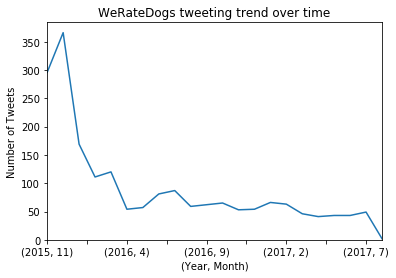

In [90]:
data = df.tweet_id.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).count()
ax = data.plot('line', title='WeRateDogs tweeting trend over time')
ax.set_xlabel("(Year, Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trend')

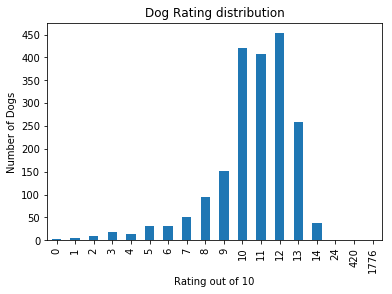

In [91]:
ax = df.rating_numerator.value_counts().sort_index().plot('bar', title = 'Dog Rating distribution')
ax.set_xlabel("Rating out of 10")
ax.set_ylabel("Number of Dogs")
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
plt.savefig('rating_dist')

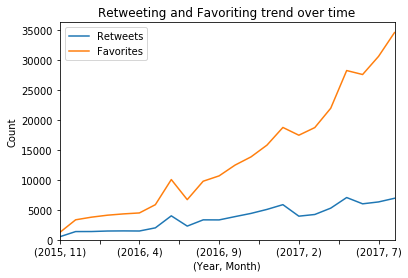

In [92]:
plt.subplots(1, sharex=True)
df.retweet_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot('line')
df.favorite_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot('line').set_ylim(0, )
plt.title('Retweeting and Favoriting trend over time')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.legend(('Retweets', 'Favorites'))
plt.savefig('ret_fav')

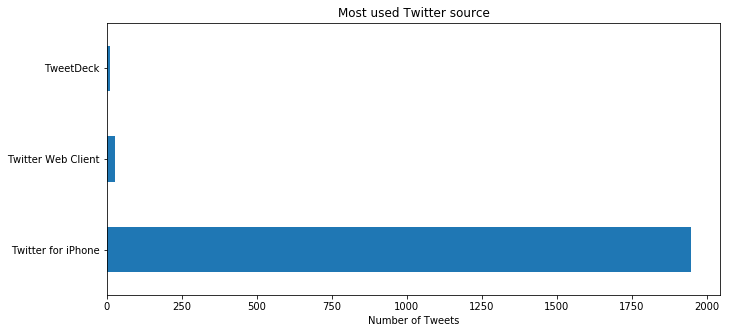

In [93]:
df['source'].value_counts().plot('barh', figsize=(11,5), title='Most used Twitter source').set_xlabel("Number of Tweets")
plt.savefig('twitter_source')

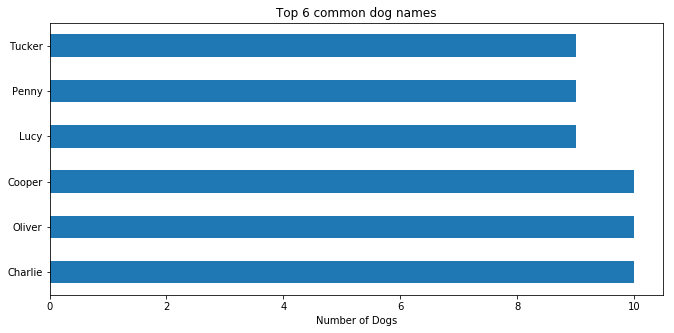

In [94]:
df.name.value_counts()[1:7].plot('barh', figsize=(11,5), title='Top 6 common dog names').set_xlabel("Number of Dogs")
plt.savefig('dog_names')